# Webscraping Newspaper - Analysen

## Vorbereitungen

In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [20]:
INPUT_PATH = os.path.join("../input/data-lake")
SQL_PATH = os.path.join("../output/dwh.sqlite3")

In [21]:
connection = sqlite3.connect(SQL_PATH)

In [22]:
wcount = pd.read_sql_query("SELECT * from wordcount_data;", connection)

In [23]:
log = pd.read_sql_query("SELECT * from log_data;", connection)

In [24]:
# Join log_data <> wordcount_data
query = """  
SELECT *
FROM log_data INNER JOIN wordcount_data
WHERE log_data.file_name = wordcount_data.file_name
"""
data = pd.read_sql_query(query, con=connection)
data.head(5)

,name,date,file_name,status,original_url,final_url,encoding,count,word,file_name
0,abendblatt,2021-03-03,data-lake/2021-03-03-abendblatt.html,200,https://www.abendblatt.de/,https://www.abendblatt.de/,UTF-8,1,cum-ex,data-lake/2021-03-03-abendblatt.html
1,abendblatt,2021-03-13,data-lake/2021-03-13-abendblatt.html,200,https://www.abendblatt.de/,https://www.abendblatt.de/,UTF-8,1,cum-ex-affäre,data-lake/2021-03-13-abendblatt.html
2,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,cum-ex-affäre,data-lake/2021-03-13-handelsblatt.html
3,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,imagecum-ex-skandal oberlandesgericht,data-lake/2021-03-13-handelsblatt.html
4,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,„cum-ex“-ausschuss,data-lake/2021-03-13-handelsblatt.html


In [25]:
# Spalte "week" Kalenderwoche hinzufügen
data['week'] = pd.to_datetime(data['date']).dt.year.astype(str) + "-" + pd.to_datetime(data['date']).dt.week.astype(str)
data.head(5)

C:\Users\Conny\AppData\Local\Temp\ipykernel_15448\3367177099.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week'] = pd.to_datetime(data['date']).dt.year.astype(str) + "-" + pd.to_datetime(data['date']).dt.week.astype(str)


,name,date,file_name,status,original_url,final_url,encoding,count,word,file_name,week
0,abendblatt,2021-03-03,data-lake/2021-03-03-abendblatt.html,200,https://www.abendblatt.de/,https://www.abendblatt.de/,UTF-8,1,cum-ex,data-lake/2021-03-03-abendblatt.html,2021-9
1,abendblatt,2021-03-13,data-lake/2021-03-13-abendblatt.html,200,https://www.abendblatt.de/,https://www.abendblatt.de/,UTF-8,1,cum-ex-affäre,data-lake/2021-03-13-abendblatt.html,2021-10
2,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,cum-ex-affäre,data-lake/2021-03-13-handelsblatt.html,2021-10
3,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,imagecum-ex-skandal oberlandesgericht,data-lake/2021-03-13-handelsblatt.html,2021-10
4,handelsblatt,2021-03-13,data-lake/2021-03-13-handelsblatt.html,200,https://www.handelsblatt.com/,https://www.handelsblatt.com/,utf-8,1,„cum-ex“-ausschuss,data-lake/2021-03-13-handelsblatt.html,2021-10


## Analysen

### Häufigste "Cum-Ex" Begriffe 

In [26]:
df = wcount.groupby("word").sum("count").sort_values(by="count",ascending=False)
df.shape

(49, 1)

### Plot Berichterstattung zu Cum-Ex (gesamt)  
An 72 Tagen des betrachteten Zeitraums vom 335 Tagen gab es Erwähnungen / Artikel zu Cum-Ex in den 3 betrachteten News-Portalen, also im Durchschnitt alle 4,6 Tage.  
Das Thema war also sehr präsent.  
Lediglich im Juni (Sommerloch?) und im September (vor der Bundestagswahl) wurde das Thema kaum aufgegriffen.  

In [27]:
query = """
SELECT sum(count), date
FROM log_data INNER JOIN wordcount_data
WHERE log_data.file_name = wordcount_data.file_name
GROUP BY date;
"""
x = pd.read_sql_query(query, con=connection)
x = x.rename(columns={"sum(count)": "Nennungen Cum-Ex", "date": "Datum"})
x

,Nennungen Cum-Ex,Datum
0,1,2021-03-03
1,6,2021-03-13
2,2,2021-03-18
3,1,2021-03-20
4,5,2021-03-25
...,...,...
67,1,2022-01-04
68,1,2022-01-09
69,2,2022-01-13
70,2,2022-01-19


In [28]:
c = data.pivot_table(values="count", index="date", aggfunc=sum)
c = c.rename(columns={"count": "Anzahl Cum-Ex-Nennungen"})
c = c.fillna(0)
#c

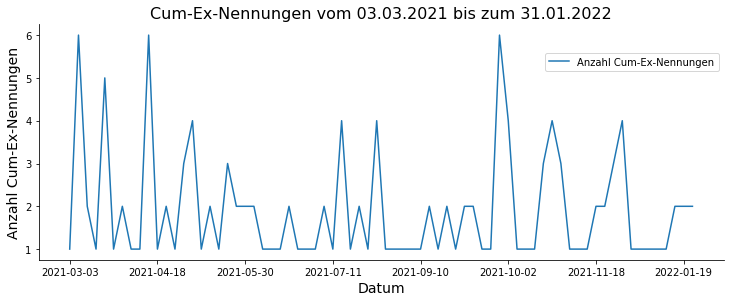

In [29]:
c.plot.line()
plt.tight_layout()
plt.rcParams["figure.figsize"] = (10,4)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)        
ax.spines["right"].set_visible(False) 
plt.ylabel("Anzahl Cum-Ex-Nennungen", size=14)
plt.xlabel("Datum", size=14)
plt.title("Cum-Ex-Nennungen vom 03.03.2021 bis zum 31.01.2022", fontsize=16, ha="center");
plt.savefig(os.path.join( "../temp", "cum-ex_all_media.png"),dpi=200, bbox_inches='tight')

### Nennung "Cum-Ex" pro Newsletter-Portal

In [30]:
query = """
SELECT sum(count), name
FROM log_data INNER JOIN wordcount_data
WHERE log_data.file_name = wordcount_data.file_name
GROUP BY name;
"""
x = pd.read_sql_query(query, con=connection).sort_values(["sum(count)", "name"], ascending=False)
x = x.rename(columns={"sum(count)": "Nennungen Cum-Ex", "name": "News_Portal"})
x

,Nennungen Cum-Ex,News_Portal
1,61,handelsblatt
0,47,abendblatt
2,30,sz


In allen drei deutschen News-Portalen finden wir Erwähnungen von Cum-Ex, am häufigsten im Handelsblatt mit 61 Nennungen.
Interessant ist, dass das Thema in der internationalen Presse keine Erwähnung fand.
Weder CNN, BBC noch The Economist berichteten im Zusammenhang mit dem Cum-Ex-Skandal.

### Plot Berichterstattung zu Cum-Ex (nach News-Portal)
Zeitraum: vom 03.03.2021 bis zum 31.01.2022 (wöchentlich)

In [31]:
p = data.pivot_table(values="count", index="week", columns="name", aggfunc=sum)
p = p.fillna(0)
p = p.rename(columns={"abendblatt": "Abendblatt", "handelsblatt": "Handelsblatt", "sz": "Sueddeutsche"})
#p

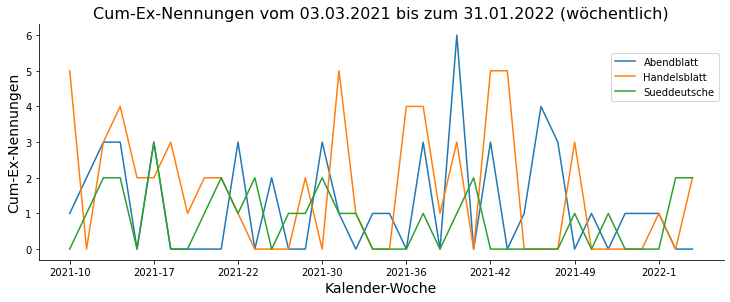

In [32]:
p.plot.line()
plt.tight_layout()
plt.rcParams["figure.figsize"] = (10,4)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)        
ax.spines["right"].set_visible(False) 
plt.ylabel("Cum-Ex-Nennungen", size=14)
plt.xlabel("Kalender-Woche", size=14)
plt.title("Cum-Ex-Nennungen vom 03.03.2021 bis zum 31.01.2022 (wöchentlich)", fontsize=16, ha="center");
plt.savefig(os.path.join( "../temp", "cum-ex_per_newspaper.png"),dpi=200, bbox_inches='tight')

**Ergebnis:**
Das Thema Cum-Ex ist nach wie vor sehr präsent in den Medien und wird immer wieder aufgegriffen.  
Es fallen einige Zeiträume auf, in denen alle 3 deutschen News-Portale verstärkt berichtet haben:  
**Kalenderwoche 13 bis 15** (29.03.2021 - 18.04.2021)    
**Kalenderwoche 30 bis 32** (26.07.2021 - 15.08.2021)     
**Kalenderwoche 36 bis 38** (05.09.2021 - 25.09.2021)  

### Analyse der Überschriften  

#### Cum-Ex-Überschriften Süddeutsche Zeitung

In [33]:
query = """
SELECT header, date, name
FROM sz_header_data INNER JOIN log_data
WHERE log_data.file_name = sz_header_data.file_name
"""
sz = pd.read_sql_query(query, con=connection)
#sz.shape
#sz.head(5)

match_sz = sz.loc[sz['header'].str.contains('cum.*ex.*', regex=True, case=False)]
with pd.option_context('display.max_colwidth', None):
  display(match_sz)

,header,date,name
3584,Cum-Ex-Banker hätten frühzeitig auffliegen können,2021-04-27,sz
5895,Erster deutscher Banker zu Haftstrafe wegen Cum-Ex verurteilt,2021-06-02,sz
8386,Mr. Cum-Ex will Auslieferung aus der Schweiz verhindern,2021-07-11,sz
9963,Was hinter der Verhaftung von Mr. Cum-Ex steckt,2021-08-04,sz
10624,Wie Mr. Cum-Ex seine Goldbarren in die Schweiz schaffte,2021-08-14,sz
19412,"Schweiz will ""Mr. Cum-Ex"" ausliefern",2021-12-23,sz


#### Cum-Ex-Überschriften Handelsblatt

In [34]:
query = """
SELECT header, date, name
FROM hb_header_data INNER JOIN log_data
WHERE log_data.file_name = hb_header_data.file_name
"""
hb = pd.read_sql_query(query, con=connection)
#hb.shape
#hb.head(5)

match_hb = hb.loc[hb['header'].str.contains('cum.*ex.*', regex=True, case=False)]
with pd.option_context('display.max_colwidth', None):
  display(match_hb)

,header,date,name
2464,Wegweisender Prozess„Was habt ihr für eine Höllenmaschine?“ – Ex-Sarasin-Banker kommt wegen Cum-Ex vor Gericht,2021-05-04,handelsblatt
6248,Keine Politik-EinflussnahmeHamburger Finanzbeamtin entlastet Scholz in der Cum-Ex-Affäre,2021-08-07,handelsblatt
7660,"Cum-Ex-SteuerskandalScholz lässt Akten sperren, die ihm gefährlich werden können",2021-09-11,handelsblatt
8359,Cum-Ex-SkandalRazzia bei langjährigem Scholz-Weggefährten Kahrs,2021-09-29,handelsblatt
9226,SteuergeschäfteSchaden im Cum-Ex-Skandal möglicherweise dreimal so hoch wie gedacht,2021-10-21,handelsblatt
9307,SteuergeschäfteCum-Ex: Warburg Bank legt Verfassungsbeschwerde gegen BGH-Urteil ein,2021-10-23,handelsblatt
11088,SteueraffäreDrei deutsche Juristen im Cum-Ex-Skandal auf der Schweizer Anklagebank,2021-12-07,handelsblatt


#### Cum-Ex-Überschriften Abendblatt

In [35]:
query = """
SELECT header, date, name
FROM ab_header_data INNER JOIN log_data
WHERE log_data.file_name = ab_header_data.file_name
"""
ab = pd.read_sql_query(query, con=connection)
#ab.shape
#ab.head(5)

match_ab = ab.loc[ab['header'].str.contains('cum.*ex.*', regex=True, case=False)]
with pd.option_context('display.max_colwidth', None):
  display(match_ab)

,header,date,name
21,Cum-Ex: Tschentschers brisante Notiz auf dem Olearius-Brief,2021-03-03,abendblatt
571,Cum-Ex-Affäre: Scholz und Tschentscher sollen aussagen,2021-03-13,abendblatt
960,Cum-Ex-Affäre: Olaf Scholz soll im April im PUA aussagen,2021-03-20,abendblatt
1292,Cum-Ex-Affäre: PUA befasst sich heute mit der Zeugenliste,2021-03-26,abendblatt
1326,Cum-Ex: Untersuchungsausschuss will Olaf Scholz' Kalender,2021-03-27,abendblatt
2224,Cum-Ex-Skandal: Linke will Scholz später zur Befragung laden,2021-04-12,abendblatt
2312,Cum-Ex-Skandal: Warburg klagt auf Akteneinsicht,2021-04-14,abendblatt
2496,Cum-Ex-Skandal: Großer Streit um Aussage von Olaf Scholz,2021-04-17,abendblatt
3199,Scholz muss vor „Cum-Ex“-Ausschuss für Aufklärung sorgen,2021-04-30,abendblatt
3251,Cum-Ex-Skandal: Die Erinnerungslücken des Olaf Scholz,2021-05-01,abendblatt


#### Alle Cum-Ex-Überschriften

In [36]:
# alle Überschriften in einer Tabelle, sortiert nach Datum
all_header = pd.concat([match_sz, match_hb, match_ab], ignore_index=True).sort_values('date')
all_header.rename({"header": "Überschrift", "date": "Datum", "name": "News-Portal"}, axis=1, inplace=True)
all_header = all_header.reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
  display(all_header)

,Überschrift,Datum,News-Portal
0,Cum-Ex: Tschentschers brisante Notiz auf dem Olearius-Brief,2021-03-03,abendblatt
1,Cum-Ex-Affäre: Scholz und Tschentscher sollen aussagen,2021-03-13,abendblatt
2,Cum-Ex-Affäre: Olaf Scholz soll im April im PUA aussagen,2021-03-20,abendblatt
3,Cum-Ex-Affäre: PUA befasst sich heute mit der Zeugenliste,2021-03-26,abendblatt
4,Cum-Ex: Untersuchungsausschuss will Olaf Scholz' Kalender,2021-03-27,abendblatt
5,Cum-Ex-Skandal: Linke will Scholz später zur Befragung laden,2021-04-12,abendblatt
6,Cum-Ex-Skandal: Warburg klagt auf Akteneinsicht,2021-04-14,abendblatt
7,Cum-Ex-Skandal: Großer Streit um Aussage von Olaf Scholz,2021-04-17,abendblatt
8,Cum-Ex-Banker hätten frühzeitig auffliegen können,2021-04-27,sz
9,Scholz muss vor „Cum-Ex“-Ausschuss für Aufklärung sorgen,2021-04-30,abendblatt
